In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install remotezip opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52
#!pip install tf-models-official
#!pip install tensorflow==2.15.0
!pip install tensorflow
!pip install -qU wandb

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Conv3D, Flatten, Dropout, LSTM, MaxPooling3D, GlobalMaxPooling3D,
                                     BatchNormalization, GlobalAveragePooling3D, TimeDistributed, Reshape,
                                     Input, Concatenate, UpSampling3D, PReLU, LeakyReLU, Lambda, ELU, ReLU)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.data import Dataset
import random
import cv2
import os
import requests
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image, ImageDraw
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
import tqdm
from tensorflow.keras import backend as K
import gc

In [ ]:
print("Tensorflow version " + tf.__version__)

##try:
#  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
#except ValueError:
#  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#strategy = tf.distribute.TPUStrategy(tpu)

#print("All TPU devices: ", tf.config.list_logical_devices('TPU'))

Tensorflow version 2.15.0


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Video Processing

In [ ]:
import os
def video_num(video_path):
    video_files = []
    for root, dirs, files in os.walk(video_path):
        for file in files:
            if file.endswith('.mp4'):
                video_files.append(os.path.join(root, file))

    print(f"Found {len(video_files)} video files.")
    return video_files

In [ ]:
len(video_num("/content/drive/MyDrive/Dataset/Aggregate/Myself/"))

Found 443 video files.


443

In [ ]:
#cap = cv2.VideoCapture("/content/drive/MyDrive/Dataset/SSD_Train/Shoplifting/processed_Shoplifting (8).mp4")
#length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#print( length )

In [ ]:
def frames_from_video_file(video_path, n_frames, output_size=(120, 120), frame_step=1):

    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
      start = 0
    else:
      max_start = video_length - need_length
      start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
      for _ in range(frame_step):
        ret, frame = src.read()
      if ret:
        frame = format_frames(frame, output_size)
        result.append(frame)
      else:
        result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

In [ ]:
def format_frames(frame, output_size):

    frame_resized = tf.image.resize_with_pad(frame, *output_size)
    frame_resized = frame_resized.numpy()

    return frame_resized

In [ ]:
class FrameGenerator:
    def __init__(self, path, n_frames, training = False):
        """ Returns a set of frames with their associated label.

          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

        print(self.class_names)
        print(self.class_ids_for_name)

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            print("Processing video:", path, "Class name:", name, "Label:", self.class_ids_for_name[name])
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name]
            yield video_frames, label
            gc.collect()

**Organizing all the files, combing Augmented and Processed Videos**

In [ ]:
#labelling data with Normal and Shoplifting
fg = FrameGenerator(Path("/content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/"), 140, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

['Normal', 'Shoplifting']
{'Normal': 0, 'Shoplifting': 1}
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/Shoplifting/Copy of shorten_IMG_0161.mp4 Class name: Shoplifting Label: 1
Shape: (140, 120, 120, 3)
Label: 1


In [ ]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(fg,
                                          output_signature = output_signature)

# Check if working
#for frames, labels in train_ds.take(3):
#    print(labels)

In [ ]:
val_ds = tf.data.Dataset.from_generator(FrameGenerator(Path("/content/drive/MyDrive/Dataset/Share/Original_Aggregate_Val/"), 140),
                                        output_signature = output_signature)

['Normal', 'Shoplifting']
{'Normal': 0, 'Shoplifting': 1}


In [ ]:
#test_ds = tf.data.Dataset.from_generator(lambda: generator_wrapper(Path("/content/drive/MyDrive/Dataset/Test/"), 140),
#                                        output_signature = output_signature)

In [ ]:
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

#test_frames, test_labels = next(iter(test_ds))
#print(f'Shape of validation set of frames: {test_frames.shape}')
#print(f'Shape of validation labels: {test_labels.shape}')

Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/Normal/gaussian_processed_Normal (45).mp4 Class name: Normal Label: 0
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/Normal/gaussian_processed_Normal (26).mp4 Class name: Normal Label: 0
Shape of training set of frames: (140, 120, 120, 3)
Shape of training labels: ()
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Val/Shoplifting/Copy of iseg_resized_Shoplifting (79).mp4 Class name: Shoplifting Label: 1
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Val/Shoplifting/processed_Shoplifting (70).mp4 Class name: Shoplifting Label: 1
Shape of validation set of frames: (140, 120, 120, 3)
Shape of validation labels: ()


In [ ]:
copy_val_ds = val_ds

In [ ]:
# Configure for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(2000).prefetch(buffer_size = AUTOTUNE)

In [ ]:
train_ds = train_ds.batch(4)
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/Shoplifting/pose_Shoplifting (46).mp4 Class name: Shoplifting Label: 1
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/Shoplifting/processed_Shoplifting (54).mp4 Class name: Shoplifting Label: 1
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/Normal/gaussian_processed_Normal (11).mp4 Class name: Normal Label: 0
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/Normal/pose_Normal (62).mp4 Class name: Normal Label: 0
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/Normal/processed_Normal (35).mp4 Class name: Normal Label: 0
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/Normal/processed_Normal (27).mp4 Class name: Normal Label: 0
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Train/Normal/flipped_pose_Normal (48).mp4 Class nam

In [ ]:
val_ds = val_ds.batch(4)
val_frames, val_labels = next(iter(val_ds))

print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Val/Shoplifting/Copy of iseg_resized_Shoplifting (79).mp4 Class name: Shoplifting Label: 1
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Val/Shoplifting/processed_Shoplifting (70).mp4 Class name: Shoplifting Label: 1
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Val/Shoplifting/processed_Shoplifting (71).mp4 Class name: Shoplifting Label: 1
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Val/Shoplifting/processed_Shoplifting (72).mp4 Class name: Shoplifting Label: 1
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Val/Shoplifting/processed_Shoplifting (73).mp4 Class name: Shoplifting Label: 1
Processing video: /content/drive/MyDrive/Dataset/Share/Original_Aggregate_Val/Shoplifting/processed_Shoplifting (74).mp4 Class name: Shoplifting Label: 1
Processing video: /content/drive/MyDrive/Dataset/Share/Original_A

#Quick Visualization

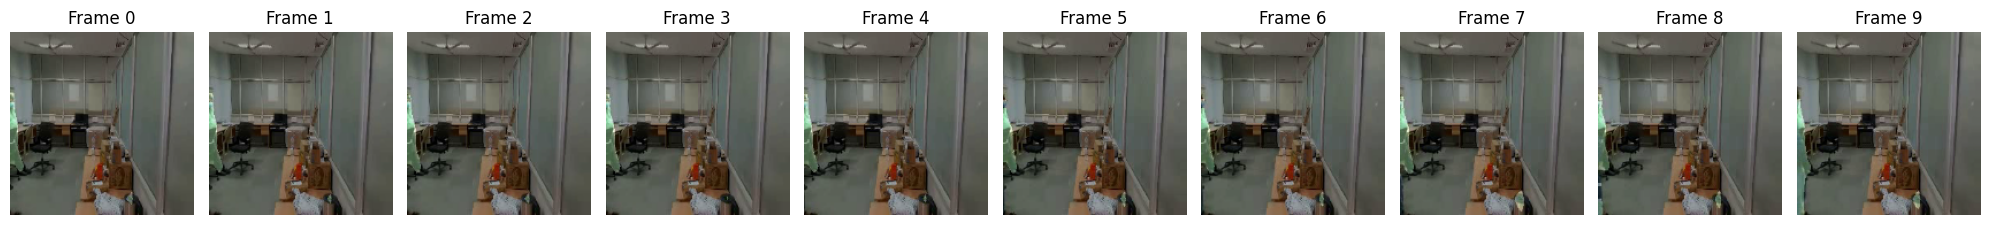

In [ ]:
%matplotlib inline
def plot_frames_from_dataset(train_ds, n_images=3):
    # Take one batch from the dataset
    for frames, labels in train_ds.take(1):
        # Select the first video in the batch
        video_frames = frames[0].numpy()  # Convert to numpy array

        # Check and correct the range of pixel values if necessary
        if video_frames.dtype != np.uint8:
            print("Warning: Frames are not in uint8 format, converting...")
            video_frames = (224 * (video_frames - np.min(video_frames)) / np.ptp(video_frames)).astype(np.uint8)

        fig, axs = plt.subplots(1, n_images, figsize=(20, 5))
        for i in range(n_images):
            # Plot each frame
            frame = video_frames[i]

            # Normalize frame for display if needed
            if np.max(frame) > 1:
                frame = frame / 224.0

            axs[i].imshow(frame)
            axs[i].set_title(f"Frame {i}")
            axs[i].axis('off')

        plt.tight_layout()
        plt.show()
        break  # Only process the first batch

# Call the function with your dataset
plot_frames_from_dataset(train_ds, n_images=10)

# Running the actual Model

In [ ]:
# wandb configuration
run = wandb.init(project='theft_prototype',
                 config={
                     "learning_rate": 0.001,
                     "epochs": 60,
                     "loss_function": "binary_crossentropy",
                     "earlystopping_patience": 40,
                 })
config = wandb.config

wandb_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=50
    ),
    WandbMetricsLogger()
]

wandb: Currently logged in as: kitchan98. Use `wandb login --relogin` to force relogin


#The Original (Main)

In [ ]:
input_shape = (16, 140, 140, 140, 3)
#inputs = Input(shape=input_shape)
inputs = Input(shape=input_shape[1:])

x = Conv3D(8, (3, 3, 3), strides=(1, 1, 1), padding='same')(inputs)
x = LeakyReLU()(x)
x = Conv3D(8, (3, 3, 3), strides=(1, 1, 1), padding='same')(x)
x = LeakyReLU()(x)
x = Conv3D(16, (3, 3, 3), strides=(1, 1, 1), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Conv3D(16, (3, 3, 3), strides=(1, 1, 1), padding='same')(x)
x = LeakyReLU()(x)

x1 = MaxPooling3D(pool_size=(2,1,1))(x)
x1 = Conv3D(16, (3, 3, 3), strides=(1, 1, 1), padding='same')(x1)
x1 = LeakyReLU()(x1)
x1 = Conv3D(32, (5, 5, 5), strides=(1, 1, 1), padding='same')(x1)
x1 = LeakyReLU()(x1)
x1 = Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding='same')(x1)
x1 = LeakyReLU()(x1)
x1 = Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding='same', kernel_regularizer = 'l2')(x1)
x1 = LeakyReLU()(x1)

# mid branch
x2 = MaxPooling3D(pool_size=(2,1,1))(x)
x2 = Conv3D(16, (3, 3, 3), strides=(1, 1, 1), padding='same')(x2)
x2 = LeakyReLU()(x2)
x2 = Conv3D(32, (7, 7, 7), strides=(1, 1, 1), padding='same')(x2)
x2 = LeakyReLU()(x2)
x2 = Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding='same')(x2)
x2 = LeakyReLU()(x2)
x2 = Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding='same', kernel_regularizer = 'l2')(x2)
x2 = LeakyReLU()(x2)

# Concatenate x1 and x2
x12 = Concatenate()([x1, x2])
x12 = BatchNormalization()(x12)
x12 = Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding='same')(x12)
x12 = LeakyReLU()(x12)
x12 = Conv3D(64, (3, 3, 3), strides=(2, 2, 2), padding='same')(x12)
x12 = LeakyReLU()(x12)
x12 = MaxPooling3D(pool_size=(2,2,2))(x12)

# Define the right branch of the network with x as input
x3 = Conv3D(32, (3,3,3), strides=(1,1,1), padding = 'same')(x)
x3 = LeakyReLU()(x3)
x3 = MaxPooling3D(pool_size=(2,2,2))(x3)
x3 = Conv3D(32, (3,3,3), strides=(1,1,1), padding='same')(x3)
x3 = LeakyReLU()(x3)
x3 = Conv3D(64, (3,3,3), strides=(2,1,1), padding='same')(x3)
x3 = LeakyReLU()(x3)
x3 = Conv3D(64, (3,1,1), strides=(1,1,1), padding='same', kernel_regularizer = 'l2')(x3)
x3 = LeakyReLU()(x3)
x3 = MaxPooling3D(pool_size=(2,2,2))(x3)

# Concatenate all the branches (Total)
x4 = Concatenate()([x12, x3])
x4 = BatchNormalization()(x4)
x4 = Conv3D(96, (3,3,3), strides=(1,1,1), padding='same')(x4)
x4 = LeakyReLU()(x4)
x4 = Conv3D(96, (3,3,3), strides=(1,1,1), padding='same')(x4)
x4 = PReLU()(x4)
x4 = BatchNormalization()(x4)

# Flatten and add the fully connected layers
x4 = Lambda(lambda x: K.sum(x, axis=1))(x4)
x4 = Flatten()(x4)
x4 = Dense(1024)(x4)
x4 = LeakyReLU()(x4)
x4 = Dropout(0.4)(x4)
x4 = Dense(128)(x4)
x4 = LeakyReLU()(x4)
x4 = Dropout(0.4)(x4)
outputs = Dense(3, activation='softmax')(x4)

# Create the model
tf.keras.backend.clear_session()
model = Model(inputs, outputs)

#0.0005 has been the best learning rate
model.compile(loss=config.loss_function, optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(train_ds,
        epochs=config.epochs,
        #batch_size = config.batch_size,
        validation_data=val_ds,
        callbacks= [wandb_callbacks, ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=9, verbose=1, min_delta=0.001)])

#Test Model

In [ ]:
def video_num(video_path):
    video_files = []
    for root, dirs, files in os.walk(video_path):
        for file in files:
            if file.endswith('.mp4'):
                video_files.append(os.path.join(root, file))

    print(f"Found {len(video_files)} video files.")
    return video_files

len(video_num('/content/drive/MyDrive/Dataset/Share/'))

Found 985 video files.


985

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # train_dist = strategy.experimental_distribute_dataset(train_ds)
    # val_dist = strategy.experimental_distribute_dataset(val_ds)

    input_shape = (8, 140, 120, 120, 3)
    inputs = Input(shape=input_shape[1:])

    x = Conv3D(8, (3, 3, 3), strides=(1, 1, 1), padding='same')(inputs)
    x = ReLU()(x)
    x = Conv3D(8, (3, 3, 3), strides=(1, 1, 1), padding='same')(x)
    x = ReLU()(x)
    x = Conv3D(16, (3, 3, 3), strides=(1, 1, 1), padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling3D(pool_size=(2,2,2))(x)
    x = Conv3D(16, (3, 3, 3), strides=(1, 1, 1), padding='same')(x)
    x = ReLU()(x)

    x1 = Conv3D(16, (3, 3, 3), strides=(1, 1, 1), padding='same')(x)
    x1 = ELU()(x1)
    x1 = Conv3D(16, (5, 5, 5), strides=(1, 1, 1), padding='same')(x1)
    x1 = ELU()(x1)
    x1 = Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding='same')(x1)
    x1 = ELU()(x1)
    x1 = MaxPooling3D(pool_size=(2,2,2))(x1)
    x1 = Conv3D(32, (5, 5, 5), strides=(1, 1, 1), padding='same', kernel_regularizer = 'l2')(x1)
    x1 = ELU()(x1)

    # Define the right branch of the network with x as input
    x3 = Conv3D(32, (3,3,3), strides=(1,1,1), padding = 'same')(x)
    x3 = ReLU()(x3)
    x3 = Conv3D(32, (3,3,3), strides=(1,1,1), padding='same')(x3)
    x3 = ReLU()(x3)
    x3 = Conv3D(64, (3,3,3), strides=(1,1,1), padding='same')(x3)
    x3 = ReLU()(x3)
    x3 = MaxPooling3D(pool_size=(2,2,2))(x3)
    x3 = Conv3D(64, (3,3,3), strides=(1,1,1), activation = 'relu', padding='same', kernel_regularizer = 'l2')(x3)

    # Concatenate all the branches (Total)
    x4 = Concatenate()([x1, x3])
    x4 = BatchNormalization()(x4)
    x4 = Conv3D(96, (3,3,3), strides=(1,1,1))(x4)
    x4 = ELU()(x4)
    x4 = Conv3D(96, (3,3,3), strides=(1,1,1), kernel_regularizer = 'l2')(x4)
    x4 = ELU()(x4)
    x4 = MaxPooling3D(pool_size=(2,2,2))(x4)
    x4 = BatchNormalization()(x4)

    # Flatten and add the fully connected layers
    x4 = Lambda(lambda x: K.sum(x, axis=1))(x4)
    x4 = Flatten()(x4)
    x4 = Dense(1024)(x4)
    x4 = ELU()(x4)
    x4 = Dropout(0.5)(x4)
    x4 = Dense(128)(x4)
    x4 = ReLU()(x4)
    x4 = Dropout(0.4)(x4)
    outputs = Dense(3, activation='softmax')(x4)

    # Create the model
    #tf.keras.backend.clear_session()
    model = Model(inputs, outputs)

    #0.0005 has been the best learning rate
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 140, 120, 120, 3)]   0         []                            
                                                                                                  
 conv3d_47 (Conv3D)          (None, 140, 120, 120, 8)     656       ['input_5[0][0]']             
                                                                                                  
 re_lu_23 (ReLU)             (None, 140, 120, 120, 8)     0         ['conv3d_47[0][0]']           
                                                                                                  
 conv3d_48 (Conv3D)          (None, 140, 120, 120, 8)     1736      ['re_lu_23[0][0]']            
                                                                                            

In [ ]:
model.fit(train_ds,
        epochs=config.epochs,
        #batch_size = config.batch_size,
        validation_data=val_ds,
        callbacks= [wandb_callbacks, ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=9, verbose=1, min_delta=0.001)])

Epoch 1/60
      6/Unknown - 30s 415ms/step - loss: 55.9105 - accuracy: 0.5417

169/169 [==============================] - 127s 588ms/step - loss: 32.7585 - accuracy: 0.4896 - val_loss: 19.8825 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 2/60
169/169 [==============================] - 80s 471ms/step - loss: 9.8579 - accuracy: 0.5222 - val_loss: 9.0996 - val_accuracy: 0.4853 - lr: 0.0010
Epoch 3/60
169/169 [==============================] - 80s 472ms/step - loss: 1.3433 - accuracy: 0.5695 - val_loss: 0.9928 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 4/60
169/169 [==============================] - 80s 473ms/step - loss: 1.0541 - accuracy: 0.5533 - val_loss: 0.6996 - val_accuracy: 0.6515 - lr: 0.0010
Epoch 5/60
169/169 [==============================] - 80s 473ms/step - loss: 0.9106 - accuracy: 0.5917 - val_loss: 1.4015 - val_accuracy: 0.5244 - lr: 0.0010
Epoch 6/60
169/169 [==============================] - 80s 473ms/step - loss: 0.9034 - accuracy: 0.5888 - val_loss: 0.7121 - val_accuracy: 0.5668 - lr: 0.0010
Epoch 7/60
169/169 [==============================] - 80s 47

# Evaluate the performance of the model

#Softmax

In [ ]:
copy_val_ds = copy_val_ds.batch(1)

In [ ]:
y_true = np.concatenate([np.array([y]) for x, y in copy_val_ds], axis=0)
y_pred = model.predict(copy_val_ds)

In [ ]:
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
print(conf_matrix)

In [ ]:
accuracy = accuracy_score(y_true, np.argmax(y_pred, axis=1))
precision = precision_score(y_true, np.argmax(y_pred, axis=1), average='weighted')
recall = recall_score(y_true, np.argmax(y_pred, axis=1), average='weighted')
f1 = f1_score(y_true, np.argmax(y_pred, axis=1), average='weighted')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')


In [ ]:
model.save('/content/drive/MyDrive/Dataset/model_latestv1.keras')

#Binary Classification

In [ ]:
copy_val_ds = copy_val_ds.batch(1)

In [ ]:
y_true = np.concatenate([np.array([y]) for x, y in copy_val_ds], axis=0)

Processing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/flipped_shorten_resized_Copy of shoplift_6.mp4 Class name: Pockets Label: 2
Processing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (70).mp4 Class name: Pockets Label: 2
Processing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (77).mp4 Class name: Pockets Label: 2
Processing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (78).mp4 Class name: Pockets Label: 2
Processing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (87).mp4 Class name: Pockets Label: 2
Processing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (65).mp4 Class name: Pockets Label: 2
Processing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (66).mp4 Class name: Pockets Label: 2
Processing video: /content/drive/MyDrive/Dataset/

In [ ]:
y_pred = model.predict(copy_val_ds)

Processing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/flipped_shorten_resized_Copy of shoplift_6.mp4 Class name: Pockets Label: 2
Processing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (70).mp4 Class name: Pockets Label: 2
      1/Unknown 5s 5s/stepProcessing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (77).mp4 Class name: Pockets Label: 2
Processing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (78).mp4 Class name: Pockets Label: 2
      3/Unknown 6s 443ms/stepProcessing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (87).mp4 Class name: Pockets Label: 2
      4/Unknown 6s 593ms/stepProcessing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets/iseg_resized_Shoplifting (65).mp4 Class name: Pockets Label: 2
      5/Unknown 7s 667ms/stepProcessing video: /content/drive/MyDrive/Dataset/Aggregate_Val/Pockets

In [ ]:
test_preds_binary = (y_pred > 0.5).astype(int)

In [ ]:
conf_matrix = confusion_matrix(y_true, test_preds_binary)
print(conf_matrix)

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [ ]:
accuracy = accuracy_score(y_true, test_preds_binary)
precision = precision_score(y_true, test_preds_binary)
recall = recall_score(y_true, test_preds_binary)
f1 = f1_score(y_true, test_preds_binary)
roc_auc = roc_auc_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

In [ ]:
# PR Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(y_true, test_preds_binary)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

"""plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()"""

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate TPR, FPR, and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the AUC
auc = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--') # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Dataset/modelv9.keras')

# Test Set

In [ ]:
test_ds = test_ds.batch(1)

In [ ]:
y_true = np.concatenate([np.array([y]) for x, y in test_ds], axis=0)

In [ ]:
y_pred = model.predict(test_ds)

In [ ]:
test_preds_binary = (y_pred > 0.5).astype(int)

In [ ]:
conf_matrix = confusion_matrix(y_true, test_preds_binary)
print(conf_matrix)

[[21  0]
 [ 5 37]]


In [ ]:
accuracy = accuracy_score(y_true, test_preds_binary)
precision = precision_score(y_true, test_preds_binary)
recall = recall_score(y_true, test_preds_binary)
f1 = f1_score(y_true, test_preds_binary)
roc_auc = roc_auc_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

Accuracy: 0.9206349206349206
Precision: 1.0
Recall: 0.8809523809523809
F1 Score: 0.9367088607594937
ROC-AUC: 0.9863945578231292


**save the model**

**Double Check the Evaluation Metrics**

In [ ]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for data, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = predicted > 0.5
  predicted = tf.cast(predicted, tf.int32)

  return actual, predicted

In [ ]:
actual, predicted = get_actual_predicted_labels(copy_val_ds)

218/218 ━━━━━━━━━━━━━━━━━━━━ 652s 3s/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
conf_matrix = confusion_matrix(actual, predicted)
print(conf_matrix)

[[103   2]
 [102  11]]


In [ ]:
accuracy1 = accuracy_score(actual, predicted)
accuracy1

0.5229357798165137

# Inference

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Dataset/modelv2.keras")

In [ ]:
# Predict on unseen data
def prepare_video_by_skipping_frames(input_video_path, output_frames=140, resolution=(160, 160)):
    # Capture video
    cap = cv2.VideoCapture(input_video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_factor = max(1, total_frames // output_frames)

    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Skip frames
        #if frame_count % skip_factor == 0:
        #    if len(frames) < output_frames:
        #        # Resize frame
        #        resized_frame = cv2.resize(frame, resolution)
        #        frames.append(resized_frame)
        frames.append(frame)
        frame_count += 1

    return np.array(frames)

# Example usage
video_clip = prepare_video_by_skipping_frames("/content/drive/MyDrive/Dataset/Validation/Shoplifting/Shoplifting (90).mp4")
video_clip

In [ ]:
predictions = model.predict(np.array([video_clip]))
predictions

# Ignore Everything Below

# Vivit Model

In [ ]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

This layer adds positional information to the encoded video tokens.

In [ ]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = ops.arange(0, num_tokens, 1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens


In [ ]:
DATASET_NAME = "organmnist3d"
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (120, 160, 160, 3)

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 20

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

PROJECTION_DIM = 128

In [ ]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=(120, 160, 160, 3),
    transformer_layers=5,
    num_heads=5,
    embed_dim=64,
    layer_norm_eps=1e-6,
    num_classes=1,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=ops.gelu),
                layers.Dense(units=embed_dim, activation=ops.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="sigmoid")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=['accuracy',
                  keras.metrics.Precision(name='precision'),
                  keras.metrics.Recall(name='recall'),
                  keras.metrics.AUC(name='auc')]
        )

    # Train the model.
    _ = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

    _, accuracy, precision, recall, auc = model.evaluate(val_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test accuracy: {round(precision * 100, 2)}%")
    print(f"Test accuracy: {round(recall * 100, 2)}%")
    print(f"Test accuracy: {round(auc * 100, 2)}%")

    return model


model = run_experiment()

# MovieNet Model

In [ ]:
model_id = 'a0'

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


In [ ]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [ ]:
model = build_classifier(5, 120, 160, backbone, 2)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_ds, epochs=20, validation_data=val_ds)

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(loss=loss_obj, optimizer='adam', metrics=['accuracy'])

In [ ]:
results = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    validation_freq=1,
                    verbose=1)

In [ ]:
#!git clone https://github.com/tensorflow/models.git

In [ ]:
#!git clone https://github.com/keras-team/keras-io.git

In [ ]:
#model = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1")

In [ ]:
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, model_url, output_shape=None, **kwargs):
        super(HubLayer, self).__init__(**kwargs)
        self.model_url = model_url
        self.output_shape = output_shape
        self.hub_layer = hub.KerasLayer(self.model_url, output_shape=self.output_shape, trainable=False)

    def call(self, inputs):
        return self.hub_layer(inputs)

# Initialize your custom layer with the URL of the model
i3d_layer = HubLayer("https://tfhub.dev/deepmind/i3d-kinetics-400/1")

# Now you can add it to a Sequential model
model = models.Sequential([
    i3d_layer,
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assuming `train_data` and `train_labels` are prepared
model.fit(train_ds, epochs = 20, validation_data = val_ds)

In [ ]:
predictions = model.predict(val_ds)

9/9 [==============================] - 16s 400ms/step


In [ ]:
def i3d_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))  # Adjust the input shape as needed

    # Load the I3D model from TensorFlow Hub
    i3d_layer = hub.KerasLayer("https://tfhub.dev/deepmind/i3d-kinetics-400/1", trainable=False)
    x = i3d_layer(inputs)

    # Example of additional layers after the I3D model output
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = i3d_model()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_ds, epochs = 20, validation_data = val_ds)

In [ ]:
def feature_extractor(inputs):
  feature_extractor_layer = tf.keras.applications.resnet.ResNet50(
      input_shape = (224, 224, 3),
      include_top = False,
      weights = 'imagenet')(inputs)

  feature_extractor_layer.trainable = False
  features = feature_extractor_layer(inputs)
  return features

In [ ]:
def classifier(inputs):
    #x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(1024, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

    return x

In [ ]:
def final_model(inputs):
  mo_feature_extractor = feature_extractor(inputs)
  classification_output = classifier(mo_feature_extractor)

  return classification_output

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
outputs = final_model(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#with tf.device("/GPU:0"):
#  model.fit(train_ds, epochs = 20, validation_data = val_ds)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Deep Learning Model 2 - Transformer

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.47      1.00      0.64        21
           1       0.00      0.00      0.00        24

    accuracy                           0.47        45
   macro avg       0.23      0.50      0.32        45
weighted avg       0.22      0.47      0.30        45



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!git clone https://github.com/google-research/scenic.git
!cd scenic
!pip install .

In [ ]:
cd ../

/content/drive/MyDrive


In [ ]:
!pip install -r /content/drive/MyDrive/scenic/scenic/projects/vivit/requirements.txt

In [ ]:
vit = tf.saved_model.load("/content/drive/MyDrive/scenic/tf_saved_model/")

In [ ]:
infer = vit.signatures['serving_default']
input_tensor = tf.constant((10, 50, 224, 224, 3), dtype=tf.float32)
predictions = infer(input_tensor)

In [ ]:
# Save the model
#model_version = max([int(i) for i in os.listdir("../models")+[0]]) + 1
#model.save(f"../models/{model_version}")

In [ ]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(2),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          epochs = 10,
          validation_data = val_ds)

# Standard 3D CNN

In [ ]:
model = Sequential([
    Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same', activation="relu", input_shape=(60, 224, 224, 3)),
    Conv3D(128, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same', activation="relu"),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.25),

    Conv3D(128, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same', activation="relu"),
    Conv3D(256, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same', activation="relu"),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.25),

    Conv3D(256, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same', activation="relu"),
    Conv3D(256, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same', activation="relu"),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.25),

    Conv3D(128, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same', activation="relu"),
    Conv3D(128, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same', activation="relu"),
    GlobalAveragePooling3D(),

    BatchNormalization(),
    Flatten(),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


# A3DConvNet-15 Deep Learning Model





In [ ]:
# Input layer
input_shape = (3, 110, 160, 160, 3)  # This will need to be adjusted to match your actual input dimensions
inputs = Input(shape=input_shape[1:])

x = Conv3D(8, (3,3,3), strides=(1,1,1), padding='same')(inputs)
x = Conv3D(8, (3,3,3), strides=(1,1,1), padding='same')(x)
x = Conv3D(16, (3,3,3), strides=(1,1,1), padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2), padding='same')(x)
x = Conv3D(16, (3,3,3), strides=(1,1,1), padding='same')(x)

x1 = MaxPooling3D(pool_size=(2,1,1), padding='same')(x)
x1 = Conv3D(16, (3,3,3), strides=(1,1,1), padding='same')(x1)
x1 = Conv3D(32, (5,5,5), strides=(1,1,1), padding='same')(x1)
x1 = Conv3D(32, (3,3,3), strides=(1,1,1), padding='same')(x1)
x1 = Conv3D(32, (3,3,3), strides=(1,1,1), padding='same')(x1)

# mid branch
x2 = MaxPooling3D(pool_size=(2,1,1), padding='same')(x)
x2 = Conv3D(16, (3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu')(x2)
x2 = Conv3D(32, (7, 7, 7), strides=(1, 1, 1), padding='same', activation='relu')(x2)
x2 = Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu')(x2)

# concatenate x1 and mid branch
x12 = Concatenate()([x1, x2])
x12 = BatchNormalization()(x12)
x12 = Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu')(x12)
x12 = MaxPooling3D(pool_size=(2,2,2), padding='same')(x12)
x12 = Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu')(x12)
x12 = MaxPooling3D(pool_size=(2,2,2), padding='same')(x12)

# Define the right branch of the network
x3 = Conv3D(32, (3,3,3), strides=(2,2,2), padding='same')(x)
x3 = MaxPooling3D(pool_size=(2,2,2), padding='same')(x3)
x3 = Conv3D(32, (3,3,3), strides=(1,1,1), padding='same')(x3)
x3 = UpSampling3D(size=(2, 2, 2))(x3)
x3 = Conv3D(64, (3,3,3), strides=(2,1,1), padding='same')(x3)
x3 = Conv3D(64, (3,1,1), strides=(1,1,1), padding='same')(x3)
x3 = MaxPooling3D(pool_size=(2,2,2), padding='same')(x3)

# Concatenate all the branches (Total)
x4 = Concatenate()([x12, x3])
x4 = BatchNormalization()(x4)
x4 = Conv3D(96, (3,3,3), strides=(1,1,1), padding='same')(x4)
x4 = Conv3D(96, (3,3,3), strides=(1,1,1), padding='same')(x4)
x4 = BatchNormalization()(x4)

# Flatten and add the fully connected layers
x4 = GlobalMaxPooling3D()(x4) #information loss here?
x4 = Flatten()(x4)
x4 = Dense(512, activation='relu')(x4)
x4 = Dropout(0.4)(x4)
x4 = Dense(128, activation='relu')(x4)
x4 = Dropout(0.4)(x4)

outputs = Dense(1, activation='sigmoid')(x4)

# Create the model
tf.keras.backend.clear_session()
model = Model(inputs, outputs)

model.summary()